In [1]:
# import tensorflow as tf
# from keras.models import Model, load_model, Sequential
# from keras.layers import Input, Dense, Flatten, Reshape, Dropout, Lambda, Embedding, InputLayer, Concatenate, Reshape, LeakyReLU
# from keras.regularizers import L1L2
# from keras.optimizers import Adam
# from keras.utils import to_categorical
# from keras.utils.vis_utils import plot_model
# import keras.backend as K
# from keras.callbacks import TensorBoard
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from packaging import version
# import tensorboard
# tensorboard.__version__
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from scipy import stats

from EM import network as net
from EM import data_prep
import json
from pathlib import Path
import os
from PIL import Image
import cv2
from joblib import Parallel, delayed

Using TensorFlow backend.


In [2]:
exp_path = 'EM/EM_Exp5/'
best_score = 1
best_id = -999
for i in range(30):
    if i > 9:
        f = open(exp_path+'tmp/'+exp_path[3:]+'trial_{}/trial.json'.format(str(i)))
        curr_iter = json.load(f)
        curr_score = curr_iter['score']
        if curr_score == None:
            continue
        print('The best score is',best_score,'and the current score is',curr_score,'and the current ID','trial_{}'.format(str(i)))
        if best_score>curr_score:
            best_score=curr_score
            best_id='trial_{}'.format(str(i))
    else:
        f = open(exp_path+'tmp/'+exp_path[3:]+'trial_0{}/trial.json'.format(str(i)))
        curr_iter = json.load(f)
        curr_score = curr_iter['score']
        print('The best score is',best_score,'and the current score is',curr_score,'and the current ID','trial_0{}'.format(str(i)))
        if best_score>curr_score:
            best_score=curr_score
            best_id='trial_0{}'.format(str(i))
print('The best trial is',best_id,'with a loss of',best_score)

The best score is 1 and the current score is 0.005912798254590745 and the current ID trial_00
The best score is 0.005912798254590745 and the current score is 0.0034767277256557436 and the current ID trial_01
The best score is 0.0034767277256557436 and the current score is 0.004177083423586957 and the current ID trial_02
The best score is 0.0034767277256557436 and the current score is 0.0065391240923693686 and the current ID trial_03
The best score is 0.0034767277256557436 and the current score is 0.005224830724976279 and the current ID trial_04
The best score is 0.0034767277256557436 and the current score is 0.003850398241833906 and the current ID trial_05
The best score is 0.0034767277256557436 and the current score is 0.006186019756238569 and the current ID trial_06
The best score is 0.0034767277256557436 and the current score is 0.004942990293858027 and the current ID trial_07
The best score is 0.0034767277256557436 and the current score is 0.0035487531397416436 and the current ID t

In [4]:
best_id='trial_01'
f = open(exp_path+'tmp/'+exp_path[3:]+best_id+'/trial.json')
best_iter = json.load(f)
best_parameters = pd.DataFrame(best_iter['hyperparameters']['values'], index=[0])
best_parameters


,hp_neigh_envelope,hp_num_complex_pairs,hp_num_real,hp_beta_units,hp_enc_dec_size,hp_delta_units,hp_l1_reg
0,5,2,5,8,16,16,9.685692e-15


In [ ]:
param_list = []
score_list = []

for i in range(20):
    if i > 9:
        best_id='trial_{}'.format(str(i))
        f = open(exp_path+'tmp/'+exp_path[3:]+best_id+'/trial.json')
    else:
        best_id='trial_0{}'.format(str(i))
        f = open(exp_path+'tmp/'+exp_path[3:]+best_id+'/trial.json')
    best_iter = json.load(f)
    best_parameters = pd.DataFrame(best_iter['hyperparameters']['values'], index=[0])

    param_list.append(best_parameters)
    score_list.append(best_iter['score'])

In [ ]:
param_for_display = 'hp_neigh_envelope'

x=[]
y=[]

for i in range(len(param_list)):
    x.append(param_list[i][param_for_display].values[0])
    y.append(score_list[i])
    
    
plt.scatter(x,y)

In [6]:
exp_data_path = exp_path+'sim_data/training/nb_neigh_{}/'.format(5)
params={}

### Experiment Parameters ###

params['state_features'] = 1
params['group_features'] = 3


### Hyper Parameters ###
params['hp_neigh_envelope'] = best_parameters['hp_neigh_envelope'].values[0]

params['hp_num_neighbors'] = 50

params['hp_num_complex_pairs'] = best_parameters['hp_num_complex_pairs'].values[0]
params['hp_num_real'] = best_parameters['hp_num_real'].values[0]

params['hp_beta_units'] = best_parameters['hp_beta_units'].values[0]

enc_dec_size = best_parameters['hp_enc_dec_size'].values[0]
params['hp_phi_enc_units'] = enc_dec_size
params['hp_psi_enc_units'] = enc_dec_size
params['hp_psi_dec_units'] = enc_dec_size

params['hp_delta_units'] = best_parameters['hp_delta_units'].values[0]

l1_reg = best_parameters['hp_l1_reg'].values[0]
params['hp_l1_reg'] = l1_reg
params['hp_l2_reg'] = l1_reg*1e-2

In [7]:
ae, pipeline = net.pipeline(params)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [ ]:
x = np.load(exp_data_path+'x_head.npy')
x_neigh = np.load(exp_data_path+'x_neigh_head.npy')
x_plus = np.load(exp_data_path+'x_plus_head.npy')
x_dot = np.load(exp_data_path+'x_dot_head.npy')
x_dot_max = np.load(exp_data_path+'x_dot_head_max.npy')
# x_dot = x_dot/x_dot.max()

In [ ]:
x.shape,x_neigh.shape,x_plus.shape,x_dot.shape

In [ ]:
x_dot_max

In [9]:
# pipeline.load_weights(exp_path+'Realizations/20230621-124537_pipeline.h5') #EM_Exp_1
pipeline.load_weights(exp_path+'Realizations/20240312-153636_pipeline.h5') #EM_Exp_5

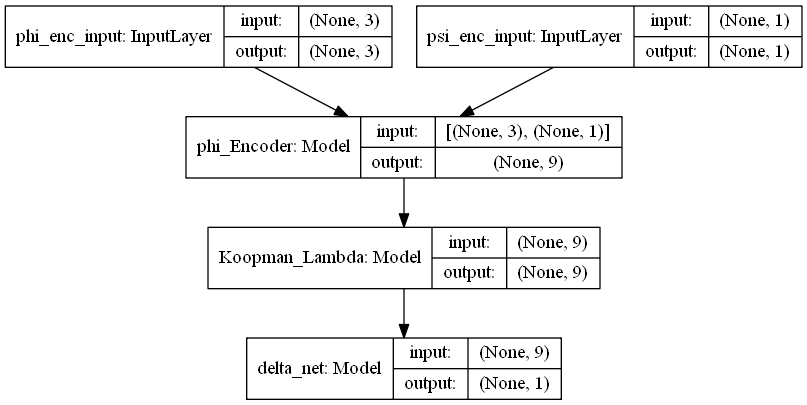

In [8]:
from keras.utils.vis_utils import plot_model
plot_model(pipeline, 'Result_Analysis/'+exp_path+"Pipeline.png", True, True)

In [ ]:
# ####################
# ### Test Dataset ###
# ####################

# ### Import Test Dataset ###

# df_master = pd.read_csv(exp_path+'sim_data/test/test1.csv', sep=' ',names=['Time', 'Agent', 'X', 'Y', 'Heading'])
# df_master.describe()

In [ ]:
# ### Scale Test Dataset ###
# X_min = -35.5
# X_max = 35.5
# Y_min = -35.5
# Y_max = 35.5
# Heading_min = 0
# Heading_max = 360

# df_scaled = df_master.copy()
# df_scaled['X'] = ((df_master['X'] - X_min)/(X_max - X_min)).values
# df_scaled['Y'] = ((df_master['Y'] - Y_min)/(Y_max - Y_min)).values
# heads = []
# for i in df_master['Heading'].values:
#     if 90 - i != abs(90 - i):
#         heads.append(450 - i)
#     else:
#         heads.append(90 - i)

# df_scaled['Heading'] = heads
# df_scaled['Heading'] = ((df_scaled['Heading'] - Heading_min)/(Heading_max - Heading_min)).values

# nb_agents = df_scaled.Agent.max() + 1
# nb_timesteps = df_scaled.Time.max() + 1

# # for i in range(nb_agents):
# #     counter = 0
# #     diff_array = np.diff(df_scaled.loc[(df_scaled.Agent == i)].Heading)
# #     for j in range(1,nb_timesteps):
# #         if abs(diff_array[j-1]) > 0.5:
# #             if diff_array[j-1]*-1 > 0:
# #                 counter += 1
# #             else:
# #                 counter -= 1
# #         df_scaled.loc[(df_scaled.Agent == i) & (df_scaled.Time == j),'Heading'] += counter 

# df_scaled.describe()

In [ ]:
# x = np.load(exp_data_path+'x_head.npy')
# x_neigh = np.load(exp_data_path+'x_neigh_head.npy')
# x_plus = np.load(exp_data_path+'x_plus_head.npy')
# x_dot = np.load(exp_data_path+'x_dot_head.npy')
# x_dot_max = np.load(exp_data_path+'x_dot_head_max.npy')

In [ ]:
# x_dot_max*360

In [ ]:
# tsteps = df_scaled['Time'].unique().shape[0]-1
# ag_nb = 100
# np.sqrt(np.square(df_scaled.loc[(df_scaled.Agent == ag_nb) & (df_scaled.Time < tsteps)]['X'].values - df_scaled.loc[(df_scaled.Agent == ag_nb) & (df_scaled.Time < (tsteps+1)) & (df_scaled.Time > 0)]['X'].values) + np.square(df_scaled.loc[(df_scaled.Agent == ag_nb) & (df_scaled.Time < tsteps)]['Y'].values - df_scaled.loc[(df_scaled.Agent == ag_nb) & (df_scaled.Time < (tsteps+1)) & (df_scaled.Time > 0)]['Y'].values))

In [ ]:
# df_scaled.loc[df_scaled['Time'] == 0,'X']= np.random.random(df_scaled.loc[df_scaled['Time'] == 0,'X'].size)
# df_scaled.loc[df_scaled['Time'] == 0,'Y']= np.random.random(df_scaled.loc[df_scaled['Time'] == 0,'Y'].size)
# df_scaled.loc[df_scaled['Time'] == 0,'Heading']= np.random.random(df_scaled.loc[df_scaled['Time'] == 0,'Heading'].size)

In [ ]:
# df_scaled.loc[df_scaled['Time'] == 0]

In [10]:
############################# Sim Visualization #################################
import tkinter
import math
from PIL import Image, ImageTk

class Boid:
    def __init__(self, agent, screen_size, db):
        self.ts = 0
        self.agent = agent
        self.x = db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].X.values[0]*screen_size
        self.y = db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].Y.values[0]*screen_size
        self.heading1 = np.arcsin(np.sin(db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].Heading.values[0] *2*np.pi))
        self.heading2 = np.arccos(np.cos(db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].Heading.values[0] *2*np.pi))
        self.color = "black"

    def draw_boid(self, canvas):
        size = 5
        x1 = self.x + size * math.cos(self.heading2)
        x2 = self.y + size * math.sin(self.heading1)
        canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)

    def flock(self, canvas, db, screen_size, window):
        if (self.ts + 5) <= db.Time.max():
            self.ts += 5
            self.x = db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].X.values[0]*screen_size
            self.y = db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].Y.values[0]*screen_size
            self.heading1 = np.arcsin(np.sin(db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].Heading.values[0] *2*np.pi))
            self.heading2 = np.arccos(np.cos(db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].Heading.values[0] *2*np.pi))
        else:
            window.destroy()
        
        self.draw_boid(canvas)

def initialise_canvas(window, screen_size):
    canvas = tkinter.Canvas(window, width=screen_size, height=screen_size)
    canvas.pack()
    window.resizable(False, False)
    return canvas

def create_boids(canvas, no_of_boids, screen_size, db):
    list_of_boids = []
    for n in range(no_of_boids):
        boid = Boid(n,screen_size,db)
        list_of_boids.append(boid)
        boid.draw_boid(canvas)
    return list_of_boids

def boid_behaviours(canvas, list_of_boids,db,screen_size,window,animation_path):
    canvas.delete('all')
    for boid in list_of_boids:
        boid.flock(canvas,db,screen_size,window)
        
    canvas.postscript(file='Result_Analysis/'+exp_path+animation_path+"my_sim_ts_{}.ps".format(list_of_boids[0].ts), colormode='color')
    canvas.after(1, boid_behaviours, canvas, list_of_boids,db,screen_size,window,animation_path)

def vizualize(db,animation_path):
    screen_size = 300
    no_of_boids = int(db.Agent.max() + 1)
    window = tkinter.Tk()
    canvas = initialise_canvas(window, screen_size)
    list_of_boids = create_boids(canvas, no_of_boids, screen_size, db)
    boid_behaviours(canvas, list_of_boids,db,screen_size,window,animation_path)
    window.mainloop()

In [11]:
def sim_test_case(max_turn_angle,neigh_env,df_scaled,nb_timesteps):
    ### Simulate Test Case ###
    # df_scaled = df_scaled.loc[df_scaled['Case'] == 1].drop(['Case'],axis=1)
    x_dot_max = max_turn_angle/360
    df_initial_state = df_scaled.loc[df_scaled['Time'] == 0].copy()
    nb_agents = df_scaled['Agent'].unique().shape[0]
    agent_velocity = 0.0028169
    for ts in range(1,nb_timesteps):
        print('Simulating Time Step',ts,'out of',nb_timesteps-1)
        flock = df_initial_state.loc[df_initial_state['Time']==ts-1][['X','Y']]
        nbrs = NearestNeighbors(n_neighbors=params['hp_num_neighbors']+1, algorithm='ball_tree').fit(flock.values)
        distances, indices = nbrs.kneighbors(flock.values)
        for agent in range(nb_agents):
            # Prepare sim inputs for current timestep using previous timestep

            # neigbours = identify_neighbours(agent,df_initial_state,ts-1)
            neigbours = indices[agent][1:]
            nb_dist = distances[agent][1:]
            # if agent == 0:
            #     print(neigbours)
            test_sim_x = data_prep.data_prep_x_group(agent,neigbours,nb_dist,df_initial_state,ts-1,k=params['hp_num_neighbors'],p=neigh_env)
            test_sim_x = test_sim_x[np.newaxis,:]

            test_x_head = np.reshape(np.asarray(test_sim_x)[:,0],(np.asarray(test_sim_x)[:,0].shape[0],-1))
            test_x_neigh_head = np.asarray(test_sim_x)[:,1:]

            old_x = df_initial_state.loc[(df_initial_state['Agent'] == agent) & (df_initial_state['Time'] == ts-1)]['X'].values[0]
            old_y = df_initial_state.loc[(df_initial_state['Agent'] == agent) & (df_initial_state['Time'] == ts-1)]['Y'].values[0]
            old_head = df_initial_state.loc[(df_initial_state['Agent'] == agent) & (df_initial_state['Time'] == ts-1)]['Heading'].values[0]

            # Predict outputs for current timestep
            y_pred = pipeline.predict([test_x_neigh_head,test_x_head])
            new_head = y_pred[0][0]*x_dot_max + old_head
            # if agent == 0:
            #     print(new_head)

            if(new_head>1):
                new_head -= 1
            elif(new_head<0):
                new_head += 1

            new_x = old_x + np.cos(2*np.pi*new_head)*agent_velocity

            if(new_x>1):
                new_x -= 1
            elif(new_x<0):
                new_x += 1

            new_y = old_y + np.sin(2*np.pi*new_head)*agent_velocity
            
            if(new_y>1):
                new_y -= 1
            elif(new_y<0):
                new_y += 1

            df_initial_state = df_initial_state.append(pd.DataFrame(np.concatenate([np.asarray([ts,agent]), np.asarray([new_x,new_y,new_head])]).reshape(1,-1),columns=list(df_initial_state)),ignore_index=True)
    
    return df_initial_state

In [13]:
test_list = ['test3','test4','test5','test1','test2']
neigh_env_list = [3,10]
max_turn_list = [9,18]
nb_timesteps = 301
exp_path = 'EM/EM_Exp5/'
# for test_case in test_list:
def pred_testcase(test_case):
    for neigh_env in neigh_env_list:
        for max_turn in max_turn_list:
            ####################
            ### Test Dataset ###
            ####################

            ### Import Test Dataset ###

            df_master = pd.read_csv(exp_path+'sim_data/test/{}.csv'.format(test_case), sep=' ',names=['Time', 'Agent', 'X', 'Y', 'Heading'])
            # df_master.describe()

            ### Scale Test Dataset ###
            X_min = -35.5
            X_max = 35.5
            Y_min = -35.5
            Y_max = 35.5
            Heading_min = 0
            Heading_max = 360

            df_scaled = df_master.copy()
            df_scaled['X'] = ((df_master['X'] - X_min)/(X_max - X_min)).values
            df_scaled['Y'] = ((df_master['Y'] - Y_min)/(Y_max - Y_min)).values
            heads = []
            for i in df_master['Heading'].values:
                if 90 - i != abs(90 - i):
                    heads.append(450 - i)
                else:
                    heads.append(90 - i)

            df_scaled['Heading'] = heads
            df_scaled['Heading'] = ((df_scaled['Heading'] - Heading_min)/(Heading_max - Heading_min)).values

            df_initial_state = sim_test_case(max_turn,neigh_env,df_scaled,nb_timesteps)
            animation_path='Simulated_results_500ts_{}_{}p{}d/'.format(test_case,neigh_env,max_turn)
            df_initial_state.to_pickle('Result_Analysis/'+exp_path+animation_path+'20240312_Simulated_results_500ts_{}_{}p{}d'.format(test_case,neigh_env,max_turn))

            df_initial_state = pd.read_pickle('Result_Analysis/'+exp_path+animation_path+'20240312_Simulated_results_500ts_{}_{}p{}d'.format(test_case,neigh_env,max_turn))
            vizualize(df_initial_state,animation_path)

            for i in range(int((nb_timesteps-1)/5)):
                psimage=Image.open('Result_Analysis/'+exp_path+animation_path+'my_sim_ts_{}.ps'.format(5*(i+1)))
                psimage.save('Result_Analysis/'+exp_path+animation_path+'my_sim_ts_{}.png'.format(5*(i+1)))

            video_name = 'Result_Analysis/'+exp_path+animation_path+'video.avi'

            images = []
            for i in range(3,int((nb_timesteps-1)/5)):
                images.append('Result_Analysis/'+exp_path+animation_path+'my_sim_ts_{}.png'.format(5*(i+1)))
            frame = cv2.imread(images[0])
            height, width, layers = frame.shape

            video = cv2.VideoWriter(video_name, 0, 3, (width,height))

            for image in images:
                video.write(cv2.imread(image))

            cv2.destroyAllWindows()
            video.release()
            
for x in test_list:
    pred_testcase(x)

Simulating Time Step 1 out of 300

Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out 

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

Simulating Time Step 1 out of 300
Simulating Time Step 2 out of 300
Simulating Time Step 3 out of 300
Simulating Time Step 4 out of 300
Simulating Time Step 5 out of 300
Simulating Time Step 6 out of 300
Simulating Time Step 7 out of 300
Simulating Time Step 8 out of 300
Simulating Time Step 9 out of 300
Simulating Time Step 10 out of 300
Simulating Time Step 11 out of 300
Simulating Time Step 12 out of 300
Simulating Time Step 13 out of 300
Simulating Time Step 14 out of 300
Simulating Time Step 15 out of 300
Simulating Time Step 16 out of 300
Simulating Time Step 17 out of 300
Simulating Time Step 18 out of 300
Simulating Time Step 19 out of 300
Simulating Time Step 20 out of 300
Simulating Time Step 21 out of 300
Simulating Time Step 22 out of 300
Simulating Time Step 23 out of 300
Simulating Time Step 24 out of 300
Simulating Time Step 25 out of 300
Simulating Time Step 26 out of 300
Simulating Time Step 27 out of 300
Simulating Time Step 28 out of 300
Simulating Time Step 29 out o

Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 1705, in __call__
    return self.func(*args)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 749, in callit
    func(*args)
  File "<ipython-input-10-cd75ea551834>", line 51, in boid_behaviours
    boid.flock(canvas,db,screen_size,window)
  File "<ipython-input-10-cd75ea551834>", line 32, in flock
    self.draw_boid(canvas)
  File "<ipython-input-10-cd75ea551834>", line 20, in draw_boid
    canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2492, in create_line
    return self._create('line', args, kw)
  File "c:\Users\dwsoumitra\.conda\envs\python_37\lib\tkinter\__init__.py", line 2480, in _create
    *(args + self._options(cnf, kw))))
_tkinter.TclError: inv

In [14]:
test_list = ['test1','test2','test3','test4','test5']
# neigh_env_list = [3,10]
# max_turn_list = [9,18]
# neigh_env_list = [3]
# max_turn_list = [9]
# nb_timesteps = 501
# exp_path = 'EM/EM_Exp5/'
for test_case in test_list:
    for neigh_env in neigh_env_list:
        for max_turn in max_turn_list:
            df_initial_state = pd.read_pickle('Result_Analysis/'+exp_path+'Simulated_results_500ts_{}_{}p{}d/'.format(test_case,neigh_env,max_turn)+'20240312_Simulated_results_500ts_{}_{}p{}d'.format(test_case,neigh_env,max_turn))
            pred_pol_l = []
            for ts in range(nb_timesteps):
                pred_head = df_initial_state.loc[df_initial_state.Time == ts].Heading
                pred_pol = np.sqrt((np.sum(np.sin(2*np.pi*pred_head)))**2 + (np.sum(np.cos(2*np.pi*pred_head)))**2)/(df_initial_state.Agent.max()+1)
                pred_pol_l.append(pred_pol)
            # plt.plot(pred_pol_l,label='Radius={};Max Turning Angle={}deg'.format(neigh_env,max_turn))
            # plt.xlabel('Timesteps')
            # plt.ylabel('Polarization')
            # plt.legend()
            print('Test Case {} Neighbour env {} Max turn {} ======= Growth rate {} %'.format(test_case,neigh_env,max_turn,np.round(np.mean(np.diff(pred_pol_l)[0:100])*100,2)))
# plt.savefig('Result_Analysis/'+exp_path+'varying_emergence.png')

Test Case test1 Neighbour env 3 Max turn 9 ======= Growth rate 0.25 %
Test Case test1 Neighbour env 3 Max turn 18 ======= Growth rate 0.31 %
Test Case test1 Neighbour env 10 Max turn 9 ======= Growth rate 0.68 %
Test Case test1 Neighbour env 10 Max turn 18 ======= Growth rate 0.76 %
Test Case test2 Neighbour env 3 Max turn 9 ======= Growth rate -0.03 %
Test Case test2 Neighbour env 3 Max turn 18 ======= Growth rate 0.17 %
Test Case test2 Neighbour env 10 Max turn 9 ======= Growth rate 0.03 %
Test Case test2 Neighbour env 10 Max turn 18 ======= Growth rate 0.18 %
Test Case test3 Neighbour env 3 Max turn 9 ======= Growth rate 0.2 %
Test Case test3 Neighbour env 3 Max turn 18 ======= Growth rate 0.41 %
Test Case test3 Neighbour env 10 Max turn 9 ======= Growth rate -0.01 %
Test Case test3 Neighbour env 10 Max turn 18 ======= Growth rate 0.08 %
Test Case test4 Neighbour env 3 Max turn 9 ======= Growth rate 0.14 %
Test Case test4 Neighbour env 3 Max turn 18 ======= Growth rate 0.26 %
Test C

In [ ]:
# for test_case in test_list:
#     for neigh_env in neigh_env_list:
#         for max_turn in max_turn_list:
#             animation_path='Simulated_results_500ts_{}_{}p{}d/'.format(test_case,neigh_env,max_turn)
#             df_initial_state = pd.read_pickle('Result_Analysis/'+exp_path+animation_path+'20240312_Simulated_results_500ts_{}_{}p{}d'.format(test_case,neigh_env,max_turn))
#             vizualize(df_initial_state)

#             for i in range(100):
#                 psimage=Image.open('Result_Analysis/'+exp_path+animation_path+'my_sim_ts_{}.ps'.format(5*(i+1)))
#                 psimage.save('Result_Analysis/'+exp_path+animation_path+'my_sim_ts_{}.png'.format(5*(i+1)))

#             video_name = 'Result_Analysis/'+exp_path+animation_path+'video.avi'

#             images = []
#             for i in range(3,100):
#                 images.append('Result_Analysis/'+exp_path+animation_path+'my_sim_ts_{}.png'.format(5*(i+1)))
#             frame = cv2.imread(images[0])
#             height, width, layers = frame.shape

#             video = cv2.VideoWriter(video_name, 0, 3, (width,height))

#             for image in images:
#                 video.write(cv2.imread(image))

#             cv2.destroyAllWindows()
#             video.release()

In [ ]:
df_initial_state.to_pickle('Result_Analysis/'+exp_path+'20240305_Simulated_results_500ts_test1_10p18d')
# df_initial_state = pd.read_pickle('Result_Analysis/'+exp_path+'20240305_Simulated_results_500ts_test1_3p18d')

In [ ]:
ag = 13
err_thresh = 0.05
plt.errorbar(range(nb_timesteps),df_scaled.loc[(df_scaled.Agent == ag) & (df_scaled.Time < nb_timesteps)].Heading,yerr=err_thresh,label='Observed')
plt.plot(range(nb_timesteps), df_initial_state.loc[(df_initial_state.Agent == ag) & (df_initial_state.Time < nb_timesteps)].Heading,label='Simulated')
plt.legend()

In [ ]:
nb_timesteps = 100

In [ ]:
for ag in range(200):
    plt.plot(range(nb_timesteps), df_initial_state.loc[(df_initial_state.Agent == ag) & (df_initial_state.Time < nb_timesteps)].Heading,label='Simulated')

In [ ]:
for ag in range(200):
    plt.plot(range(301), df_scaled.loc[(df_scaled.Agent == ag) & (df_scaled.Time < 301)].Heading,label='Observed')

In [ ]:
error_list = []
for i in range(nb_timesteps):#df_scaled['Time'].unique().shape[0]):
    pred = df_initial_state[df_initial_state.Time==i][['Heading']].values
    true = df_scaled.loc[df_scaled.Time==i][['Heading']].values
    error = np.mean(np.abs(pred-true))
    error_list.append(error)

plt.plot(error_list)
plt.xscale('log')

In [ ]:
error_list = []
for i in range(nb_timesteps):
    pred_X = df_initial_state[df_initial_state.Time==i][['X']].values
    true_X = df_scaled.loc[df_scaled.Time==i][['X']].values
    pred_Y = df_initial_state[df_initial_state.Time==i][['Y']].values
    true_Y = df_scaled.loc[df_scaled.Time==i][['Y']].values
    error = 0.5*(np.mean(np.abs(pred_X-true_X)) + np.mean(np.abs(pred_Y-true_Y)))
    error_list.append(error)

plt.plot(error_list)
plt.xscale('log')

In [ ]:
(np.array(error_list)<=0.05).sum()

In [ ]:
t_step = 10
bins = 8
df_prediction = df_initial_state.loc[(df_initial_state.Time == t_step)]
df_ground_truth = df_scaled.loc[(df_scaled.Time == t_step)]
plt.imshow(stats.binned_statistic_2d(df_ground_truth.X, df_ground_truth.Y, None, 'count', bins=bins).statistic, interpolation='quadric', vmin=0,vmax=7)
plt.colorbar()



In [ ]:
plt.imshow(stats.binned_statistic_2d(df_prediction.X, df_prediction.Y, None, 'count', bins=bins).statistic, interpolation='quadric', vmin=0,vmax=7)
plt.colorbar()

In [ ]:
pred_pol_l = []
obs_pol_l = []
for ts in range(nb_timesteps):
    pred_head = df_initial_state.loc[df_initial_state.Time == ts].Heading
    obs_head = df_scaled.loc[df_scaled.Time == ts].Heading

    pred_pol = np.sqrt((np.sum(np.sin(2*np.pi*pred_head)))**2 + (np.sum(np.cos(2*np.pi*pred_head)))**2)/(df_initial_state.Agent.max()+1)
    obs_pol = np.sqrt((np.sum(np.sin(2*np.pi*obs_head)))**2 + (np.sum(np.cos(2*np.pi*obs_head)))**2)/(df_scaled.Agent.max()+1)

    pred_pol_l.append(pred_pol)
    obs_pol_l.append(obs_pol)

In [ ]:
plt.plot(obs_pol_l,label='Observed')
plt.plot(pred_pol_l,label='Simulated')
plt.legend()

In [ ]:
np.mean(np.diff(pred_pol_l)[0:100])*100

In [ ]:
np.diff(pred_pol_l)[0:100]

In [ ]:
############################# Sim Visualization #################################
import tkinter
import math
from PIL import Image, ImageTk

class Boid:
    def __init__(self, agent, screen_size, db):
        self.ts = 0
        self.agent = agent
        self.x = db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].X.values[0]*screen_size
        self.y = db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].Y.values[0]*screen_size
        self.heading1 = np.arcsin(np.sin(db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].Heading.values[0] *2*np.pi))
        self.heading2 = np.arccos(np.cos(db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].Heading.values[0] *2*np.pi))
        self.color = "black"

    def draw_boid(self, canvas):
        size = 5
        x1 = self.x + size * math.cos(self.heading2)
        x2 = self.y + size * math.sin(self.heading1)
        canvas.create_line(self.x, self.y, x1, x2, fill='black', arrow='last', arrowshape=(12.8,16,4.8), width=2, tags=self.agent)

    def flock(self, canvas, db, screen_size, window):
        if (self.ts + 5) <= db.Time.max():
            self.ts += 5
            self.x = db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].X.values[0]*screen_size
            self.y = db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].Y.values[0]*screen_size
            self.heading1 = np.arcsin(np.sin(db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].Heading.values[0] *2*np.pi))
            self.heading2 = np.arccos(np.cos(db.loc[(db['Agent'] == self.agent) & (db['Time'] == self.ts)].Heading.values[0] *2*np.pi))
        else:
            window.destroy()
        
        self.draw_boid(canvas)

def initialise_canvas(window, screen_size):
    canvas = tkinter.Canvas(window, width=screen_size, height=screen_size)
    canvas.pack()
    window.resizable(False, False)
    return canvas

def create_boids(canvas, no_of_boids, screen_size, db):
    list_of_boids = []
    for n in range(no_of_boids):
        boid = Boid(n,screen_size,db)
        list_of_boids.append(boid)
        boid.draw_boid(canvas)
    return list_of_boids

def boid_behaviours(canvas, list_of_boids,db,screen_size,window,animation_path):
    canvas.delete('all')
    for boid in list_of_boids:
        boid.flock(canvas,db,screen_size,window)
        
    canvas.postscript(file='Result_Analysis/'+exp_path+animation_path+"my_sim_ts_{}.ps".format(list_of_boids[0].ts), colormode='color')
    canvas.after(1, boid_behaviours, canvas, list_of_boids,db,screen_size,window)

def vizualize(db,animation_path):
    screen_size = 300
    no_of_boids = int(db.Agent.max() + 1)
    window = tkinter.Tk()
    canvas = initialise_canvas(window, screen_size)
    list_of_boids = create_boids(canvas, no_of_boids, screen_size, db)
    boid_behaviours(canvas, list_of_boids,db,screen_size,window,animation_path)
    window.mainloop()

In [ ]:
vizualize(df_initial_state)
# vizualize(df_scaled)

In [ ]:
from PIL import Image

for i in range(100):
    psimage=Image.open('Result_Analysis/'+exp_path+animation_path+'my_sim_ts_{}.ps'.format(5*(i+1)))
    psimage.save('Result_Analysis/'+exp_path+animation_path+'my_sim_ts_{}.png'.format(5*(i+1)))

In [ ]:
# import imageio
# images = []
# for i in range(3,100):
#     images.append(imageio.imread('Result_Analysis/'+exp_path+'my_sim_ts_{}.png'.format(5*(i+1))))
# imageio.mimsave('Result_Analysis/'+exp_path+'movie.gif', images)

In [ ]:
import cv2
import os

image_folder = 'Result_Analysis/'+exp_path
video_name = 'video.avi'

# images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
images = []
for i in range(3,100):
    images.append('Result_Analysis/'+exp_path+animation_path+'my_sim_ts_{}.png'.format(5*(i+1)))
frame = cv2.imread(images[0])
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, 0, 3, (width,height))

for image in images:
    video.write(cv2.imread(image))

cv2.destroyAllWindows()
video.release()